In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert2 as hilbert

%matplotlib inline

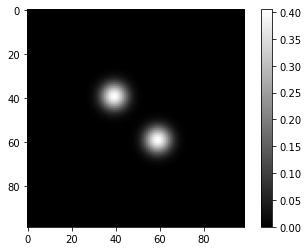

In [2]:
from scipy.fftpack import fftshift 
from scipy.fft import fft2

def Gabor2d(N, u, v, sigma):
    
    g = np.zeros((2 * N, 2*N))
    j, i = np.mgrid[-N/2 + 1: N/2, -N/2 +1:N/2]
    
    #Gaussian
    gauss = np.exp(-(i**2 + j **2) / (2 * sigma * sigma))
        
    #Normalizing the gauss
    gauss /= np.sum(gauss)
    
    
    #The image needs to be in the central part of the matrix
    start = int(N/2 + 2)
    stop = int(3* (N/2) )
    samples = stop - start + 1
    r1 = np.linspace(start, stop, samples, dtype=int)
    r2 = r1
    
    #modulating by the cosine
    gauss *= np.cos( 2 * np.pi / N*(u * i + v * j)) 
    g[np.ix_(r1,r2)] = gauss
    
    #Zero phase
    g = fftshift(g)
    
    
    
    return gauss, g


    
    
gabor, full_gabor = Gabor2d(100,10, 10, 4) 

#G
plt.imshow(fftshift(np.log(1+np.absolute(fft2(gabor)))), cmap='gray')
plt.colorbar()


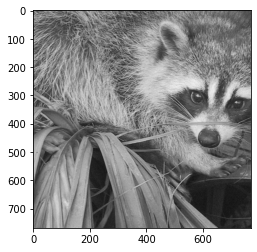

In [3]:
from scipy import misc
import imageio
import cv2
import matplotlib.pyplot as plt

f = misc.face()
imageio.imsave('face.png', f) # uses the Image module (PIL)



f_gray = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)    
N, M = f_gray.shape
f_gray = f_gray[:N, :N]


f_gray = f_gray.astype(np.float64)
original_im = f_gray.copy()
f_gray += np.random.normal(0, 7, (f_gray.shape[0],f_gray.shape[1])) 
gabor, full_gabor = Gabor2d(N,16.0, 5, 2.0) 
plt.imshow(f_gray, cmap='gray')
plt.show()


MSE: 401.03781121448833


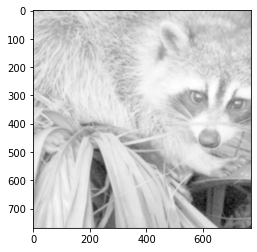

In [4]:
from scipy.fft import ifft2


def apply_gab2d(g, im):
    #Zero padding matrix
    N, _ = np.shape(im)
    samples = N
    vec = np.linspace(0, N - 1, samples, dtype=int)
    
    pad_im = np.zeros(np.shape(g))
    pad_im[np.ix_(vec, vec)] = im
    
    
    #1st recon with the full size image
    recon_img = np.real(ifft2(fft2(g) * fft2(pad_im)))
    
    #cut_img
    ct_img = recon_img[np.ix_(vec, vec)] 
    
    return ct_img
    
img = apply_gab2d(full_gabor, f_gray)

plt.imshow((np.log(1+img)), cmap='gray')
Y = np.square(np.subtract(img, f_gray)).mean()
print("MSE:", Y)

In [5]:
def gaussKern(f0, s0, overlapIndex):
    
    overlap = np.sqrt(2* np.log(1 / overlapIndex))
    sigma = s0 * overlap/(s0*f0*overlap)
    n = np.ceil(2*sigma)
    X, Y = np.mgrid[-n:n+2, -n:n+2]
    kern = np.exp(-1/2 *(X**2 + Y**2) / sigma**2)
    kern /= np.sum(kern)
    
    return kern

def gaborKern2D(theta, lamb, gamma, 
               bandwidth, phase, overlapInd):
    
    
    qFac = (1/ np.pi) * np.sqrt((np.log(overlapInd)/2)) * ((2**bandwidth + 1) / (2**bandwidth - 1))
    sigma = lamb * qFac
    N = np.ceil(4*sigma)
    X, Y = np.mgrid[-N:N+2, -N:N+2]
    
    xTheta = X * np.cos(theta) + Y * np.sin(theta)
    yTheta = -X * np.sin(theta) + Y * np.cos(theta)
    
    gaussian = np.exp(-((xTheta**2) + gamma**2 * (yTheta**2)) / (2*sigma**2))
    gabor = gaussian * np.cos(2*np.pi*xTheta / lamb  + phase)
    
    maxfft = np.max(np.abs(fft2(gabor)))
    gaborfft = fft2(gabor / maxfft)
    final_gabor = np.real(ifft2(gaborfft))
    
    
    return final_gabor, sigma

    



def setFilterBanks():
           
    #This function allows to set multiple filterbanks
    #The filterbanks parameters
    lamb0 = 2
    orientations = 8
    scales = 5
    gamma = 1
    phase = 0
    bandwidth = 1
    overlapIndex = 0.5
    offset = 0
    stop = np.pi - (np.pi / orientations) + offset
    step = np.pi / orientations
    theta = np.linspace(offset, stop, orientations)
    lamb = lamb0
    filters = {}
    numb = 0
    for scale in np.arange(scales, 0, -1):
        lamb0 = lamb
        for th in theta:
            
            result, sig = gaborKern2D(th, lamb, gamma,
                                     bandwidth, phase, 1 / overlapIndex)
            
            #filters[scale,th] = result
            filters[numb] = result
            numb +=1
            lamb = lamb0 * (2**bandwidth)
                        
            
            
    # Time to add the DC filter
    f1 =  2 * np.pi / lamb 
    result = gaussKern(f1, sig, overlapIndex)
    filters[numb+1] = result
    
    return filters
            
filters = setFilterBanks()            

0


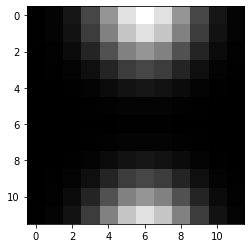

1


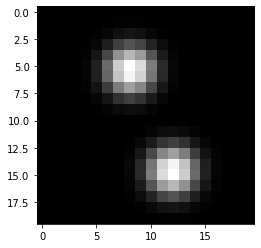

2


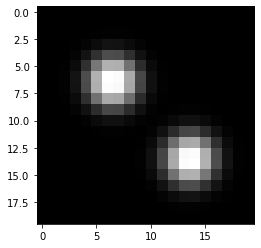

3


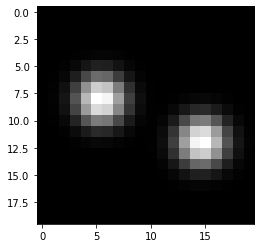

4


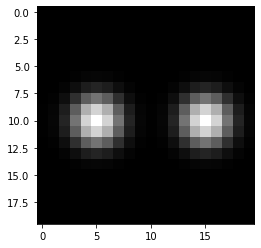

5


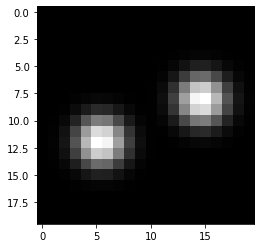

6


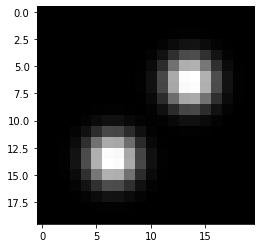

7


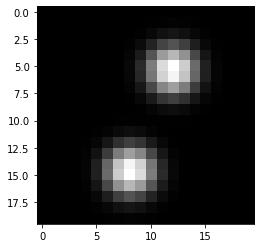

8


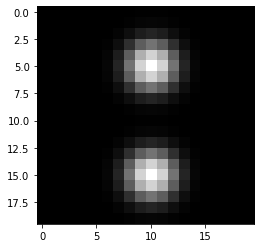

9


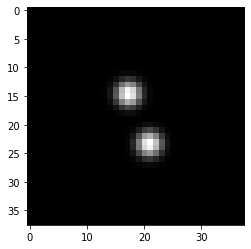

10


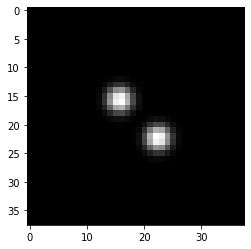

11


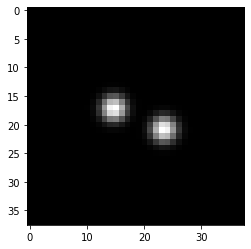

12


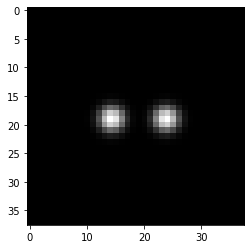

13


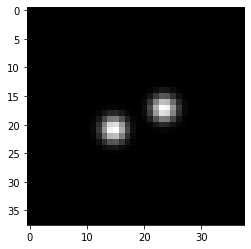

14


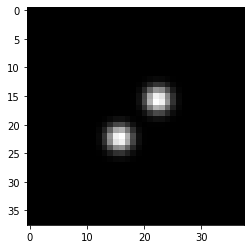

15


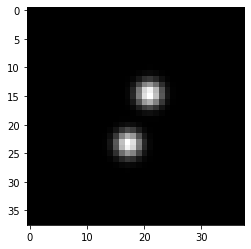

16


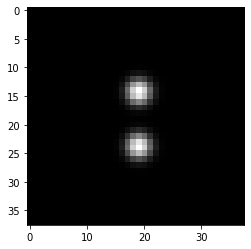

17


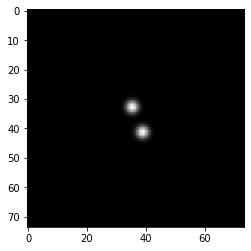

18


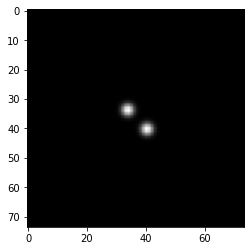

19


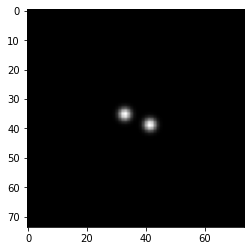

20


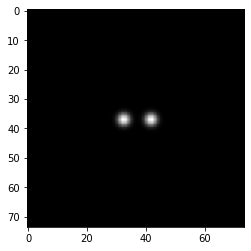

21


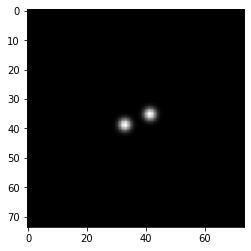

22


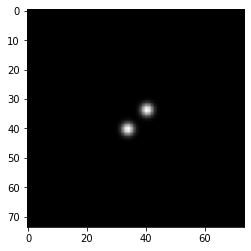

23


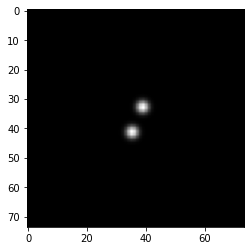

24


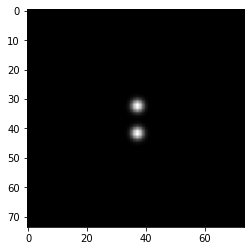

25


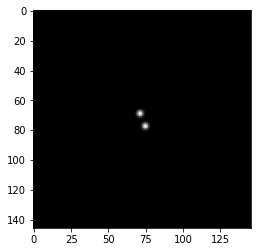

26


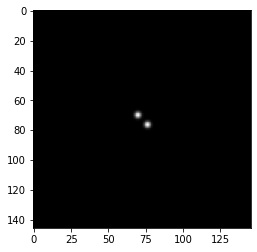

27


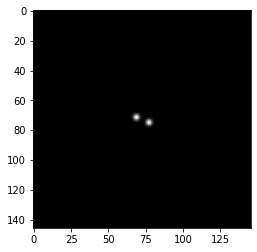

28


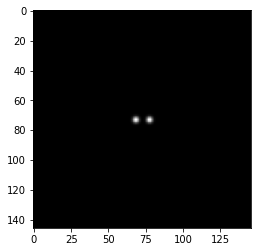

29


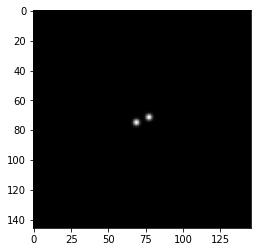

30


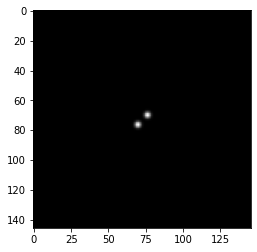

31


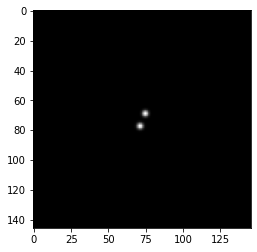

32


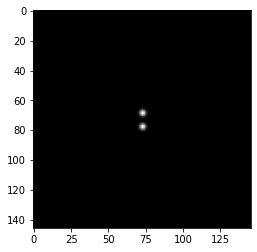

33


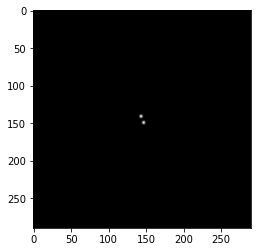

34


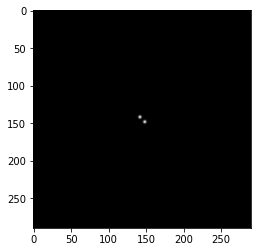

35


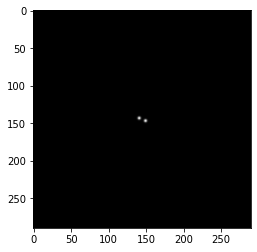

36


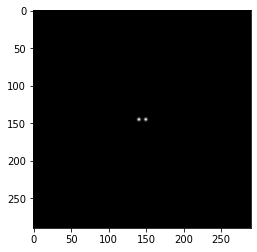

37


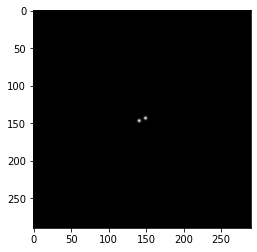

38


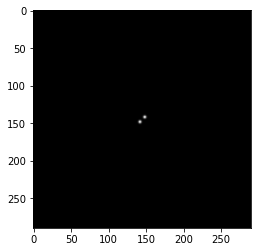

39


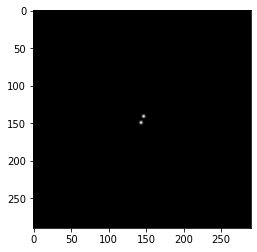

41


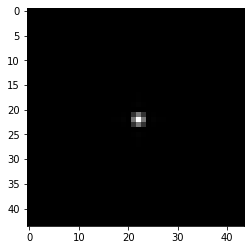

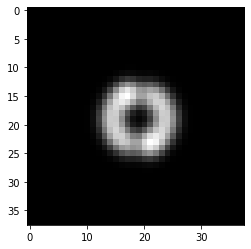

In [6]:
#plt.imshow((np.log(1+filters[1,0.0])), cmap='gray')
for key in filters.keys():
    if key >= 9 and key <16:
        if key ==9:
            A = filters[key].copy()
        
        
        A += filters[key].copy()
            
            
    print(key)
    plt.imshow(fftshift(np.log(1+np.abs(fft2(filters[key])))), cmap='gray')
    #plt.imshow((np.log(1+np.abs(fft2(filters[key])))), cmap='gray')
    plt.show()


plt.imshow(fftshift(np.log(1+np.abs(fft2(A)))), cmap='gray')
plt.show()
#plt.imshow(fftshift(np.log(1+np.abs(fft2(filters[3,0.39269908169872414])))), cmap='gray')

In [7]:
from scipy import ndimage

def calculateAMFM(img):
    #AMFM dictionary
    M, _ = img.shape  #Assuming that the rows and the columns are the same?
    #Calculate the IA
    #and then normalizing it
    IA = np.abs(img)
    #Calculating the Phase
    IP = np.angle(img)
    
    
    IAnorm = img / IA
    IFx = np.zeros(IA.shape)
    IFy = IFx.copy()
    
   
    for i in range(1, M-1):
        for j in range(1, N-1):
            IFx[i, j] = np.abs(np.arccos(np.real((IAnorm[i+1,j] + IAnorm[i-1,j]) /
                                               (2 * IAnorm[i,j]))))
            
            IFy[i, j] = np.abs(np.arccos(np.real((IAnorm[i,j+1] + IAnorm[i,j-1]) /
                                               (2 * IAnorm[i,j]))))
            
    return IA, IP, IFx, IFy
    



#AMFM part 
N, _ = f_gray.shape #Assuming that rows and cols are the same
AMFM = {}
#Convolution part
for key in list(filters.keys()):
    AMFM[key] = {}
    AMFM[key]['IA'] = {}  
    AMFM[key]['IP'] = {}
    AMFM[key]['IFx'] = {}
    AMFM[key]['IFy'] = {}
    filter_ = filters[key] 
    N_f, M_f = filter_.shape
    final_shape = 2 * N
    fft_filt = filter_   #fftshift(fft2(filter_)) #Centering
    
    #We need to pad appropriately
    row2fill = final_shape - N_f
    col2fill = final_shape - M_f
    
    if (row2fill % 2) ==0:
        top_row = int(row2fill / 2)
        bot_row = top_row
    else:
        top_row = int(np.floor(row2fill/2))
        bot_row = int(np.ceil(row2fill/2))
        
    if (col2fill % 2) ==0:
        left_col = int(col2fill / 2)
        right_col = left_col
    else:
        left_col = int(np.floor(col2fill/2))
        right_col = int(np.ceil(col2fill/2))
    
    fft_filt = np.pad(fft_filt, ((top_row,bot_row), (left_col,right_col)), 'constant')
    fft_filt = fft2(fft_filt)
    
    
    #We zero pad the image as well
    #Zero padding matrix
    N, _ = np.shape(f_gray)
    samples = N
    vec = np.linspace(0, N - 1, samples, dtype=int)
    
    pad_im = np.zeros(np.shape(fft_filt))
    pad_im[np.ix_(vec, vec)] = f_gray
    
    hImg = hilbert(pad_im)

    #filterImg = ndimage.convolve(hImg, filters[key], mode='constant')
    
    #Padding the filter
    
    
    
    filterImg = ifft2(fft2(hImg) * fft_filt)
    print("***************Calculating AMFM components*******************")
    IA, IP, IFx, IFy = calculateAMFM(filterImg)
    
    AMFM[key]['IA'] = IA
    AMFM[key]['IP'] = IP
    AMFM[key]['IFx'] = IFx
    AMFM[key]['IFy'] = IFy
    
       



***************Calculating AMFM components*******************


<ipython-input-7-5dfd21221630>:23: RuntimeWarning: invalid value encountered in arccos
  IFy[i, j] = np.abs(np.arccos(np.real((IAnorm[i,j+1] + IAnorm[i,j-1]) /
<ipython-input-7-5dfd21221630>:20: RuntimeWarning: invalid value encountered in arccos
  IFx[i, j] = np.abs(np.arccos(np.real((IAnorm[i+1,j] + IAnorm[i-1,j]) /


***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
***************Calculating AMFM components*******************
********

In [8]:
def dca(scale):
    
    all_keys = list(scale.keys()) 
    N,M = scale[all_keys[0]]['IA'].shape
    
    for row in range(0, N):
        for col in range(0,M):
            pos = all_keys[0]
            tmp = scale[pos]['IA'][row,col]
            
            for inc_pos in all_keys:
                
                if tmp < scale[inc_pos]['IA'][row,col]:
                    pos = inc_pos
                    tmp = scale[inc_pos]['IA'][row,col]
                    
            IA[row, col] = tmp
            IP[row, col] = scale[pos]['IP'][row,col]
            IFx[row, col] = scale[pos]['IFx'][row,col]
            IFy[row,col] = scale[pos]['IFy'][row,col]
            
    return IA, IP, IFx, IFy
            


#Getting the different scales
scale_dict = {}
scale_dict['high'] = {}
scale_dict['med'] = {}
scale_dict['low'] = {}
scale_dict['dc'] = {}

for numb, key in enumerate(filters.keys()):
    if key < 8:
        scale_dict['high'][key] = {}
        scale_dict['high'][key] = AMFM[key]
    elif key >= 8 and key < 24:
        scale_dict['med'][key] = {}
        scale_dict['med'][key] = AMFM[key]   
    elif key >= 24 and key < 40:
        scale_dict['low'][key] = {}
        scale_dict['low'][key] = AMFM[key] 
    else:
        scale_dict['dc'][key] = {}
        scale_dict['dc'][key] = AMFM[key]
        
IAl, IPl, IFxl, IFyl = dca(scale_dict['low'])
IAm, IPm, IFxm, IFym = dca(scale_dict['med'])
IAh, IPh, IFxh, IFyh = dca(scale_dict['high'])
IAdc, IPdc, IFxdc, IFydc = dca(scale_dict['dc'])



        
    

In [9]:
w = scale_dict['low'][24]['IA'] == scale_dict['high'][2]['IA']
np.unique(w)

array([False])

In [10]:
w= IFxl == IFxh
np.unique(w)

array([False,  True])

In [11]:
#We calculate the image gradient IF

IFl_mag = np.sqrt(IFxl**2 + IFyl**2)
IFl_ang = np.arctan2(IFxl, IFyl)

IFm_mag = np.sqrt(IFxm**2 + IFym**2)
IFm_ang = np.arctan2(IFxm, IFym)

IFh_mag = np.sqrt(IFxh**2 + IFyh**2)
IFh_ang = np.arctan2(IFxh, IFyh)


#Thresholding and reconstruction of the images at all scales
#Low scale
p=np.percentile(IAl, 50)
bound = IAl < p
IAl[bound] = 0
reconDCAl = np.real(IAl * np.cos(IPl))

#Medium scale
p=np.percentile(IAm, 50)
bound = IAm < p
IAm[bound] = 0
reconDCAm = np.real(IAm * np.cos(IPm))

#High scale
p=np.percentile(IAh, 50)
bound = IAh < p
IAh[bound] = 0
reconDCAh = np.real(IAh * np.cos(IPh))

#DC
p=np.percentile(IAdc, 50)
bound = IAdc < p
IAdc[bound] = 0
reconDCAdc = np.real(IAdc * np.cos(IPdc))

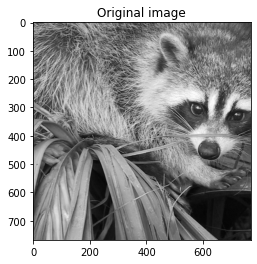

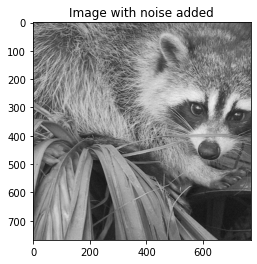

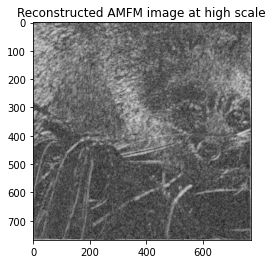

In [16]:
plt.title('Original image')
plt.imshow(original_im, cmap='gray')
plt.show()

plt.title('Image with noise added')
plt.imshow(f_gray, cmap='gray')
plt.show()

N, M = f_gray.shape
plt.title('Reconstructed AMFM image at high scale')
plt.imshow(np.log(1+np.abs(fftshift(reconDCAh ))[:N, :M]), cmap='gray')
plt.show()

In [17]:
#Calculating the reconstruction error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

final_im = fftshift(reconDCAh.copy())[:N, :M]

r2 = r2_score(f_gray, final_im)
rmse = sqrt(mean_squared_error(f_gray, final_im))

# RMSE normalised by mean:
nrmse = rmse/sqrt(np.mean(f_gray**2))

print("The normalized error is ", nrmse)

The normalized error is  0.9977125686169529


In [22]:
from numpy import linalg as LA
theta = np.arccos(LA.norm(reconDCAh) / LA.norm(f_gray))
print("Theta for the recon in degrees is", np.degrees(theta))

Theta for the recon in degrees is 84.53854285329973


In [ ]:
scale_dict['low'].keys()